# Проект: классификация

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from pandas import pivot_table
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
from sklearn.feature_selection import RFE

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [103]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [104]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [105]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [106]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def convert_float(row):
    row = str(row)
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan

df['balance'] = df['balance'].apply(convert_float)

df['balance'].mean().round(2)

1529.13

### Задание 4

In [107]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'] = df['balance'].fillna(df['balance'].median())
df['balance'].mean().round(2)

1526.94

### Задание 5

In [108]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df['education'].value_counts()

#оба столбца('job' проверен выше) имеют пропуски в виде слова unknown: заменим их на требуемые модальные значения
df['job'] = df['job'].apply(lambda x: np.nan if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: np.nan if x == 'unknown' else x)

df['job'] = df['job'].fillna(df['job'].mode())
df['education'] = df['education'].fillna(df['education'].mode())

### Задание 6

In [109]:
# удалите все выбросы для признака balance
# ваш код
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5) 
    upper_bound = quartile_3 + (iqr * 1.5) 
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned, lower_bound, upper_bound = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print ('lower_bound =', lower_bound)
print ('upper_bound =', upper_bound)

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
lower_bound = -2241.0
upper_bound = 4063.0


In [110]:
df = df[(df['balance'] >= -2241) & (df['balance'] <= 4063)]
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no


## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64

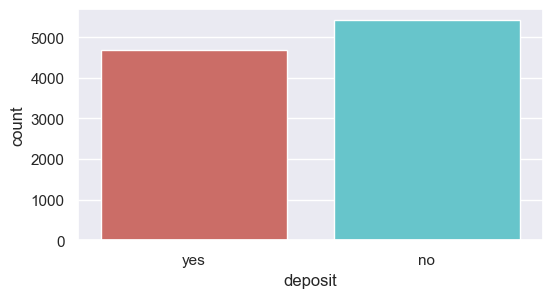

In [111]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
display(df['deposit'].value_counts())
sns.set(rc={'figure.figsize':(6,3)})
sns.countplot(data=df, palette='hls', x='deposit');

### Задания 2 и 3

In [112]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

In [113]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10044,10105,9666,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2254,5715,5078,9939,5243,8712,7283,2617,7570,5424


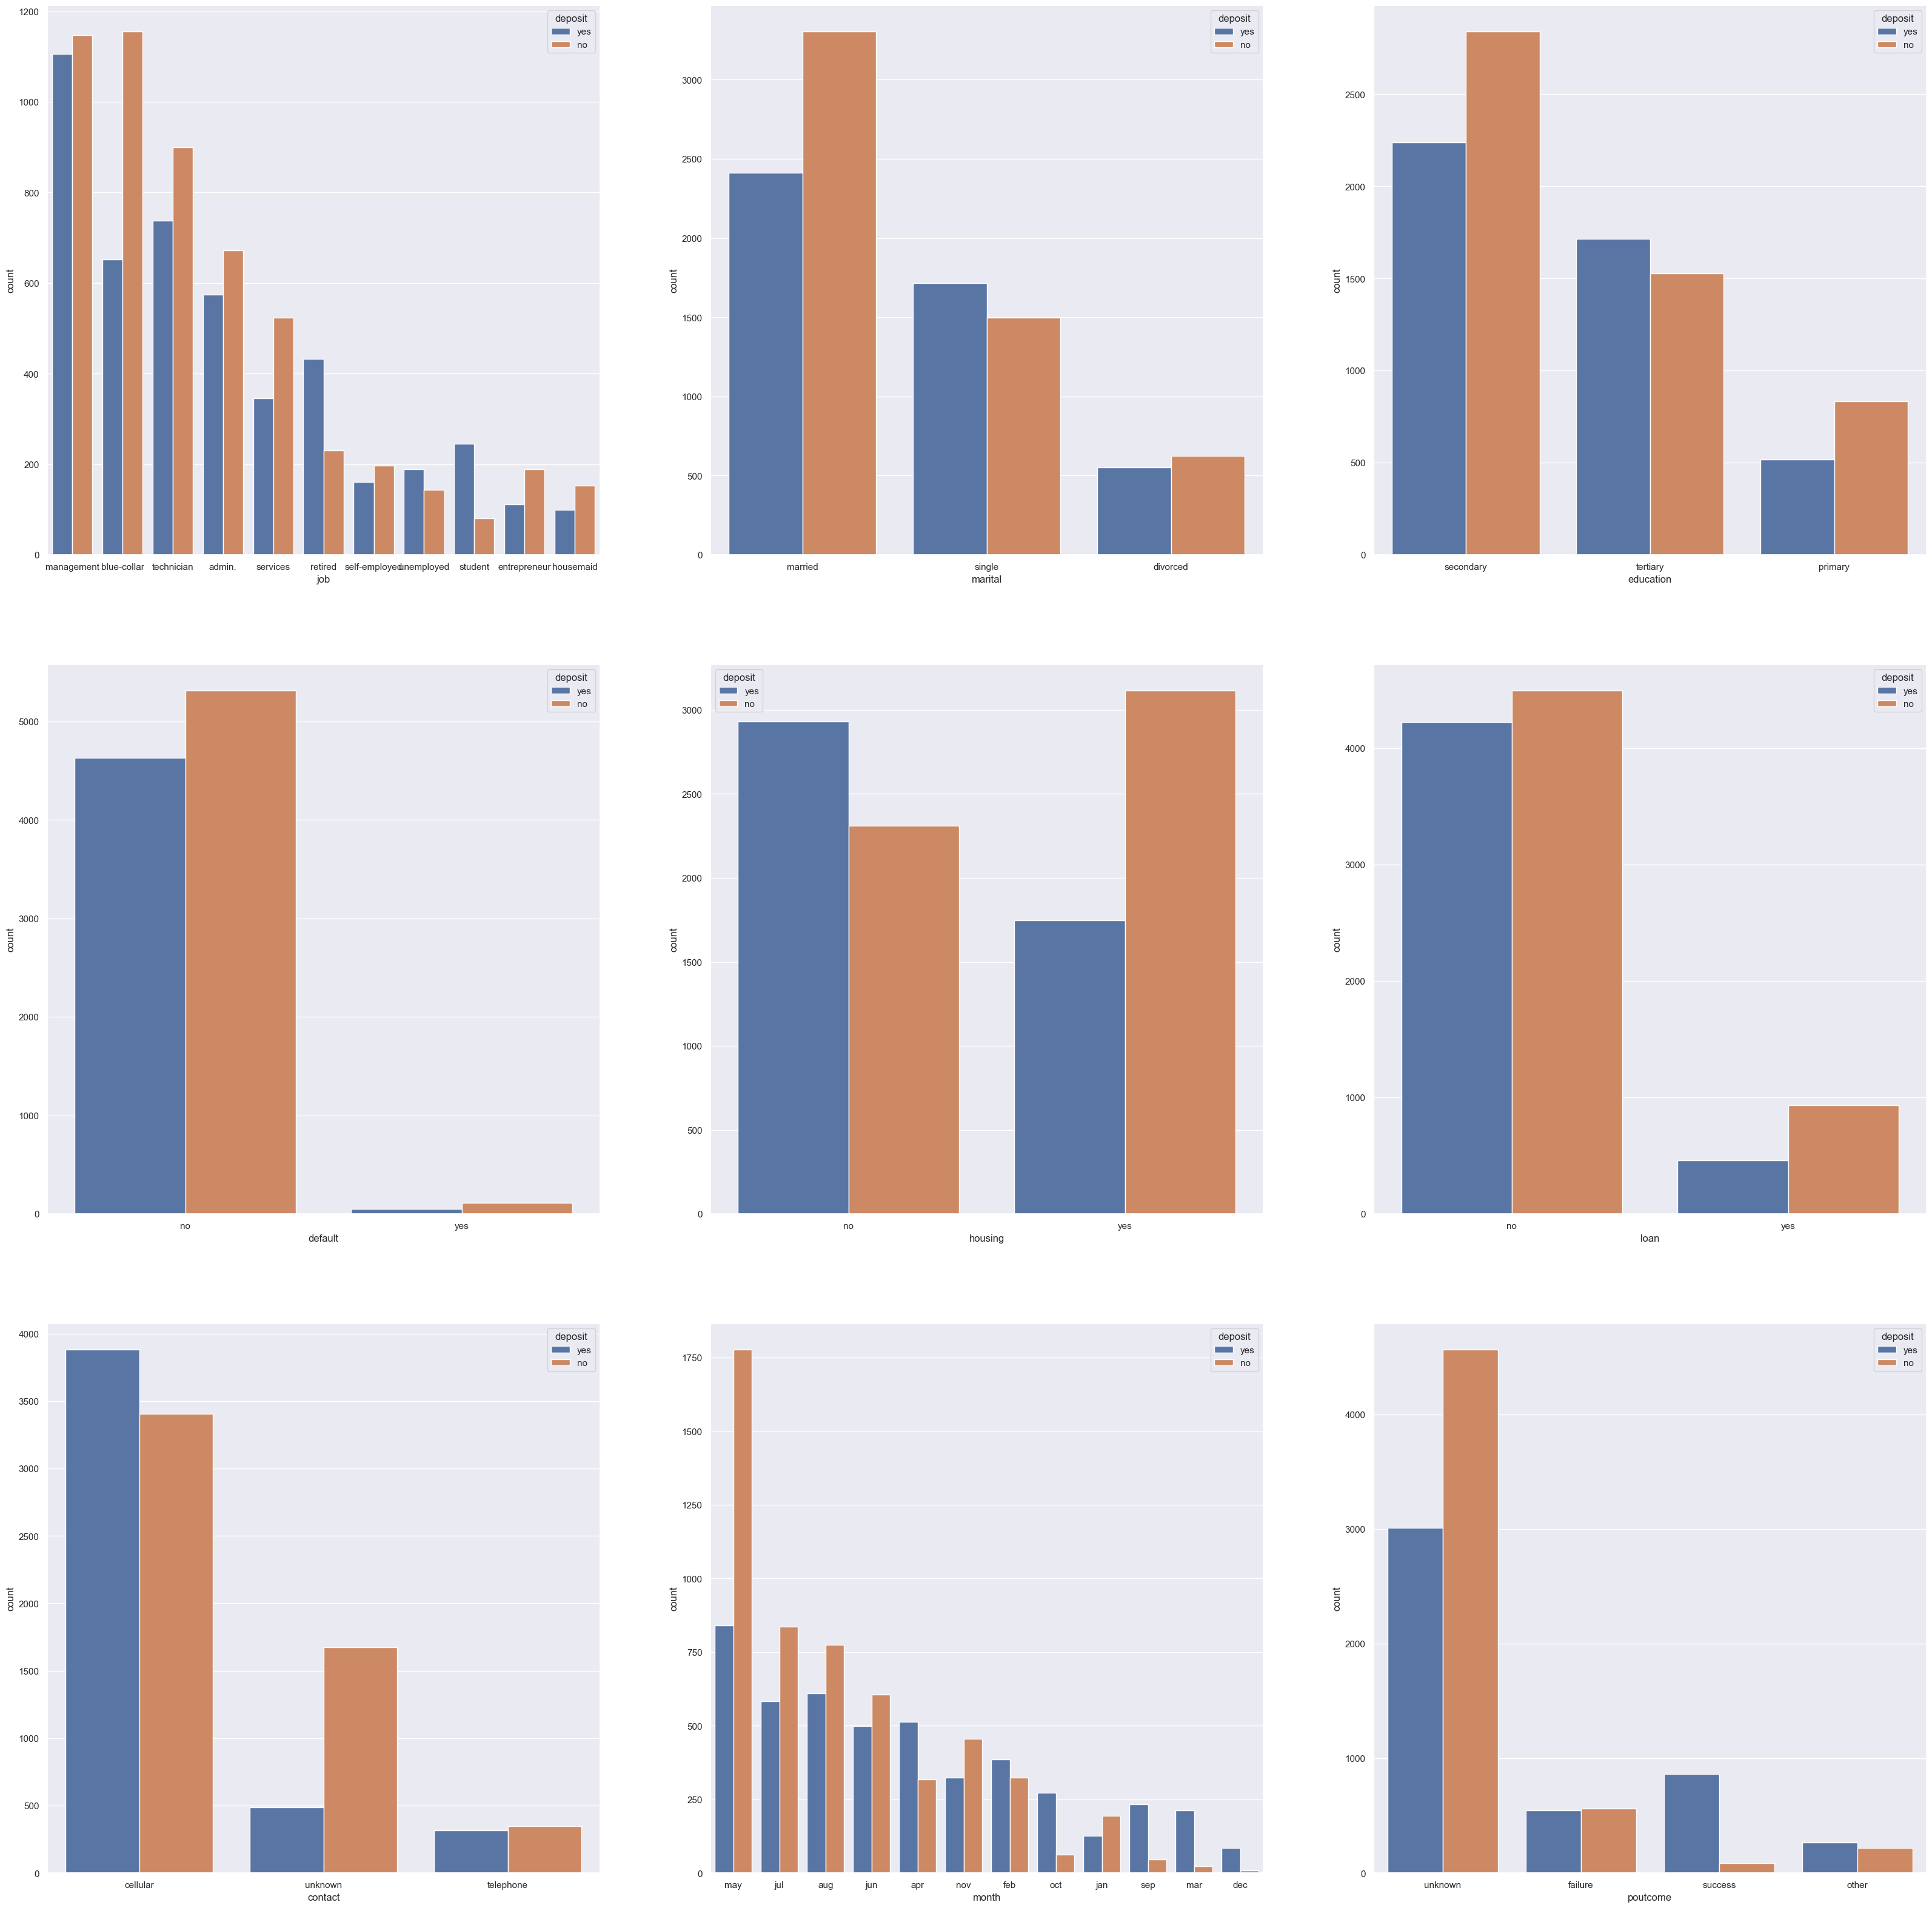

In [114]:
fig, ax = plt.subplots(3,3, figsize=(40,40))

# Профессия
sns.countplot(
    data=df, x='job', hue='deposit', 
    order=df['job'].value_counts().index, ax=ax[0,0])

# Семейное положение
sns.countplot(
    data=df, x='marital', hue='deposit',
    order=df['marital'].value_counts().index, ax=ax[0,1])

# Уровень образования
sns.countplot(
    data=df, x='education', hue='deposit',
    order=df['education'].value_counts().index, ax=ax[0,2])

# Наличие просроченного кредита
sns.countplot(
    data=df, x='default', hue='deposit',
    order=df['default'].value_counts().index, ax=ax[1,0])

# Наличие ипотеки
sns.countplot(
    data=df, x='housing', hue='deposit',
    order=df['housing'].value_counts().index, ax=ax[1,1])

# Наличие потребительского кредита
sns.countplot(
    data=df, x='loan', hue='deposit',
    order=df['loan'].value_counts().index, ax=ax[1,2])

# Тип контакта с клиентом
sns.countplot(
    data=df, x='contact', hue='deposit', 
    order=df['contact'].value_counts().index, ax=ax[2,0])

# Месяц последнего контакта с клиентом
sns.countplot(
    data=df, x='month', hue='deposit',
    order=df['month'].value_counts().index, ax=ax[2,1])

# Результат предыдущей маркетинговой кампании
sns.countplot(
    data=df, x='poutcome', hue='deposit',
    order=df['poutcome'].value_counts().index, ax=ax[2,2]);

### Задание 6

In [116]:
com_data = df.groupby(['poutcome', 'deposit'], as_index=False)[['balance']].count()
com_data = com_data.rename(columns={'balance': 'client number'})

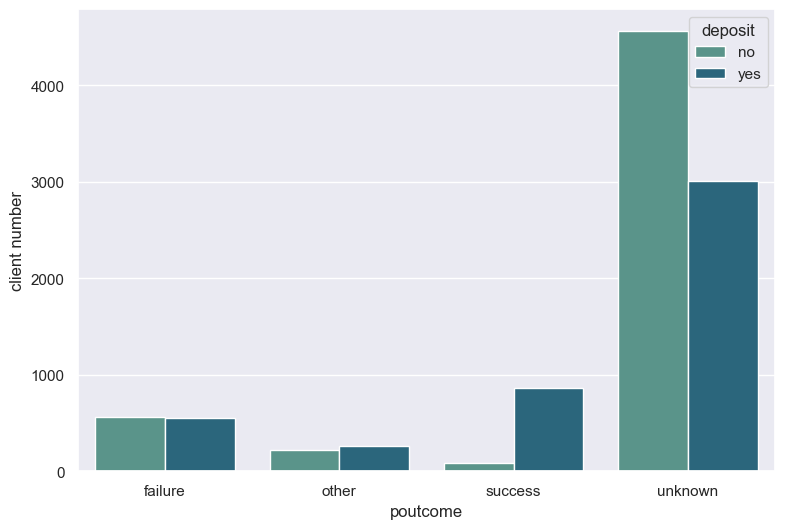

In [117]:
sns.set(rc={'figure.figsize':(9,6)})
sns.barplot(x='poutcome', y='client number', hue='deposit', data=com_data, palette='crest', orient='v');

### Задание 7

In [118]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код       
com_data = df.groupby(['month', 'deposit'], as_index=False)[['balance']].count()

com_data = com_data.rename(columns={'balance': 'client number'})

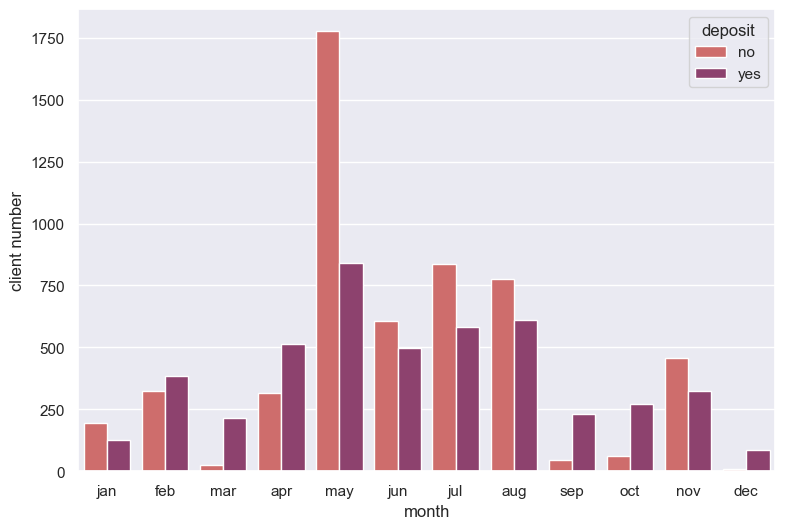

In [119]:
sns.set(rc={'figure.figsize':(9,6)})
sns.barplot(x='month', y='client number', hue='deposit', data=com_data, order=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],palette='flare', orient='v');

### Задание 8

In [120]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

def get_age(age):
    
    if age < 30:
        return '<30'
    elif 30 <= age < 40:
        return '30-39'
    elif 40 <= age < 50:
        return '40-49'
    elif 50 <= age < 60:
        return '50-59'
    else:
        return '60 +'
    
    
df['age_group'] = df['age'].apply(get_age)

In [121]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-59
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-59
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-49
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-59
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-59


In [122]:
age_data = df.groupby(['age_group', 'deposit'], as_index=False)[['balance']].count()

age_data = age_data.rename(columns={'balance': 'client number'})

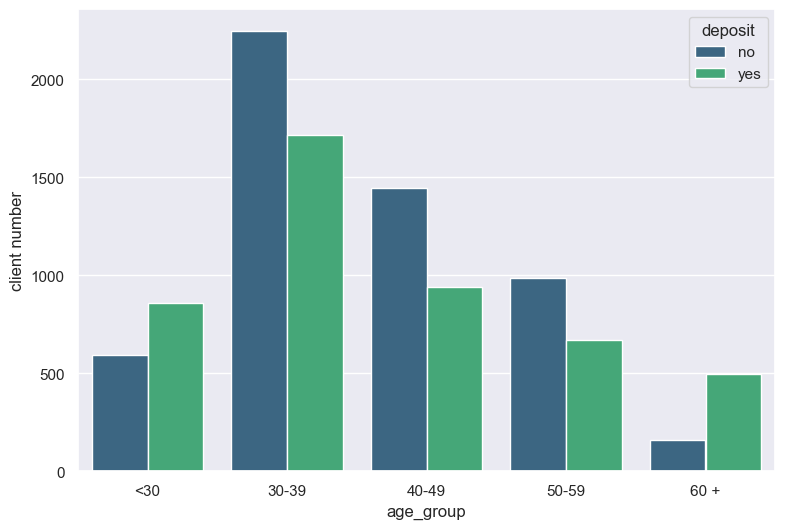

In [123]:
sns.barplot(x='age_group', y='client number', hue='deposit', data=age_data, order=['<30', '30-39', '40-49', '50-59', '60 +'], palette='viridis', orient='v');

### Задания 9 и 10

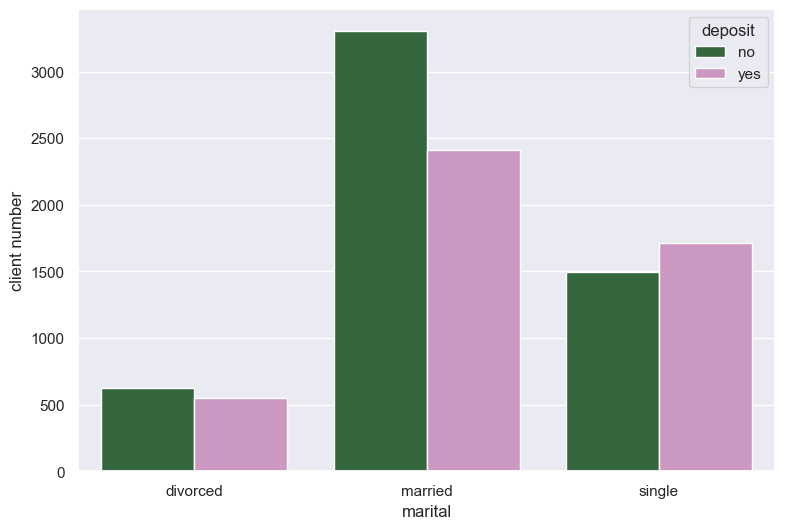

In [124]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
marital_data = df.groupby(['marital', 'deposit'], as_index=False)[['balance']].count()

marital_data = marital_data.rename(columns={'balance': 'client number'})
sns.set(rc={'figure.figsize':(9,6)})
sns.barplot(x='marital', y='client number', hue='deposit', data=marital_data, palette='cubehelix', orient='v');

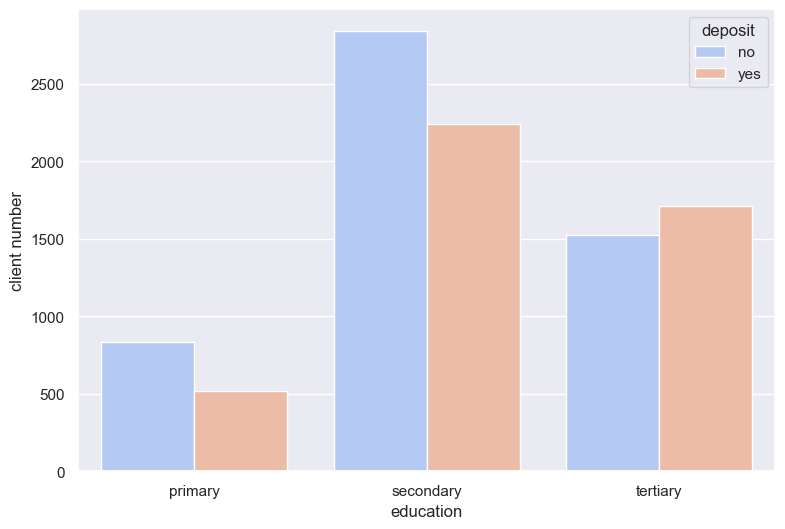

In [126]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
ed_data = df.groupby(['education', 'deposit'], as_index=False)[['balance']].count()

ed_data = ed_data.rename(columns={'balance': 'client number'})
sns.set(rc={'figure.figsize':(9,6)})
sns.barplot(x='education', y='client number', hue='deposit', data=ed_data, palette='coolwarm', orient='v');

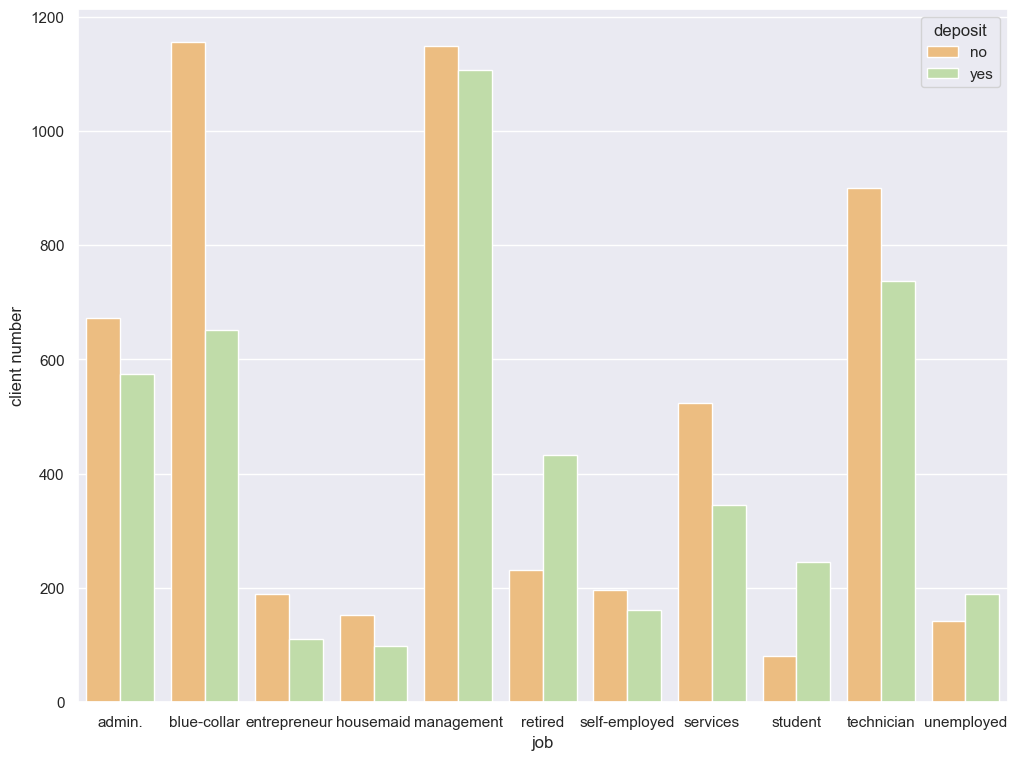

In [127]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
job_data = df.groupby(['job', 'deposit'], as_index=False)[['balance']].count()

job_data = job_data.rename(columns={'balance': 'client number'})
sns.set(rc={'figure.figsize':(12,9)})
sns.barplot(x='job', y='client number', hue='deposit', data=job_data, palette='Spectral', orient='v');

### Задание 11

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,265,1169,805
tertiary,174,784,755


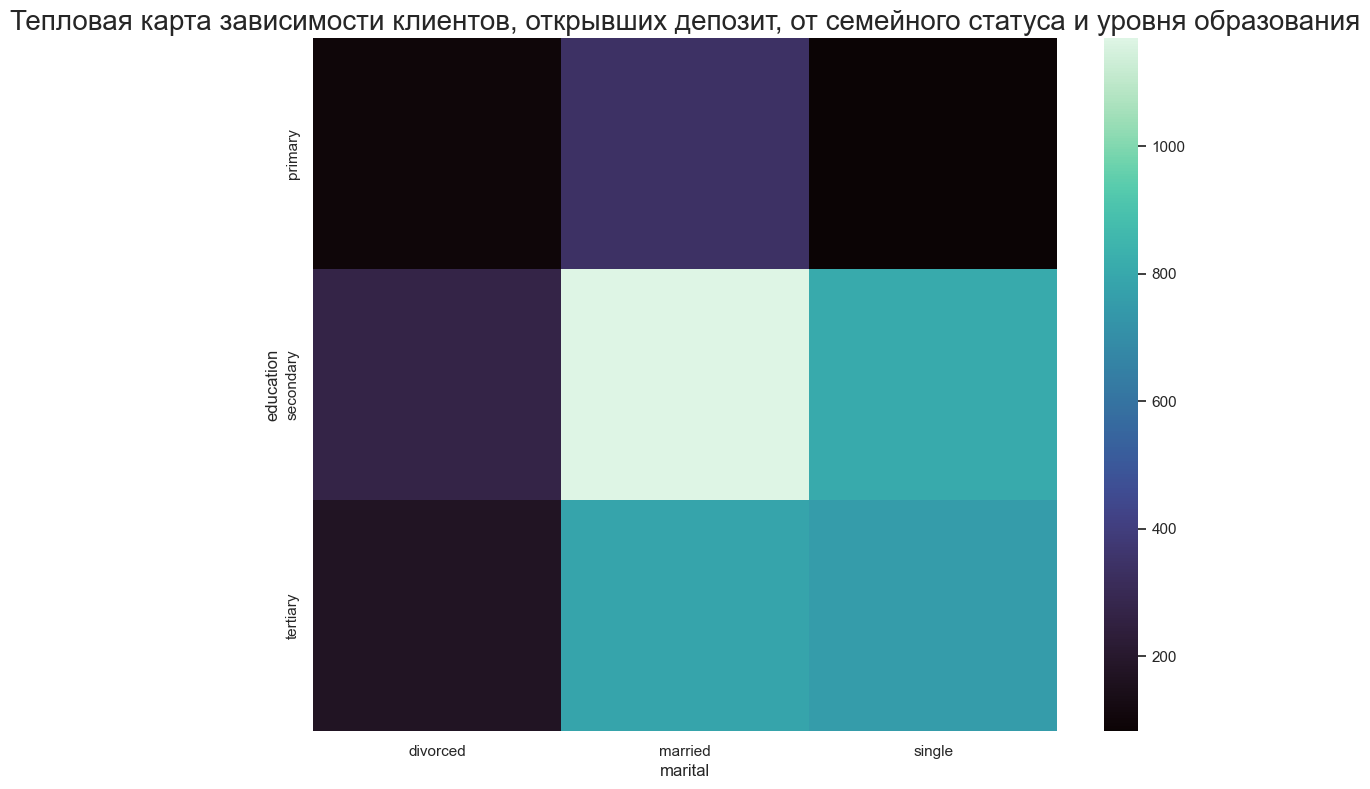

In [128]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
filtered_data = df[df['deposit'] == 'yes']

pivot_deposit_yes = filtered_data.pivot_table(
    values = 'deposit',
    columns = 'marital',
    index = 'education',
    aggfunc='count'
)
pivot_deposit_yes.columns = pivot_deposit_yes.columns.astype('string')
display(pivot_deposit_yes)

heatmap = sns.heatmap(data=pivot_deposit_yes, cmap='mako')
heatmap.set_title('Тепловая карта зависимости клиентов, открывших депозит, от семейного статуса и уровня образования', fontsize=20);

## Часть 3: преобразование данных

### Задание 1

In [129]:
# преобразуйте уровни образования
# 0 - primary, 1 - secondary, 2 - tertiary
label_enc = preprocessing.LabelEncoder()
df['education'] = label_enc.fit_transform(df['education'])

In [130]:
df['age'] = label_enc.fit_transform(df['age'])
df['age_group'] = label_enc.fit_transform(df['age_group']) 

### Задания 2 и 3

In [131]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,41,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,38,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,23,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1
3,37,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2
4,36,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2


### Задание 4

In [132]:
# создайте дамми-переменные
df = pd.get_dummies(df, columns=['job','marital', 'contact', 'month', 'poutcome'])
df.head()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,41,1,0,2343.0,1,0,5,1042,1,-1,...,0,0,1,0,0,0,0,0,0,1
1,38,1,0,45.0,0,0,5,1467,1,-1,...,0,0,1,0,0,0,0,0,0,1
2,23,1,0,1270.0,1,0,5,1389,1,-1,...,0,0,1,0,0,0,0,0,0,1
3,37,1,0,2476.0,1,0,5,579,1,-1,...,0,0,1,0,0,0,0,0,0,1
4,36,2,0,184.0,0,0,5,673,2,-1,...,0,0,1,0,0,0,0,0,0,1


### Задания 5 и 6

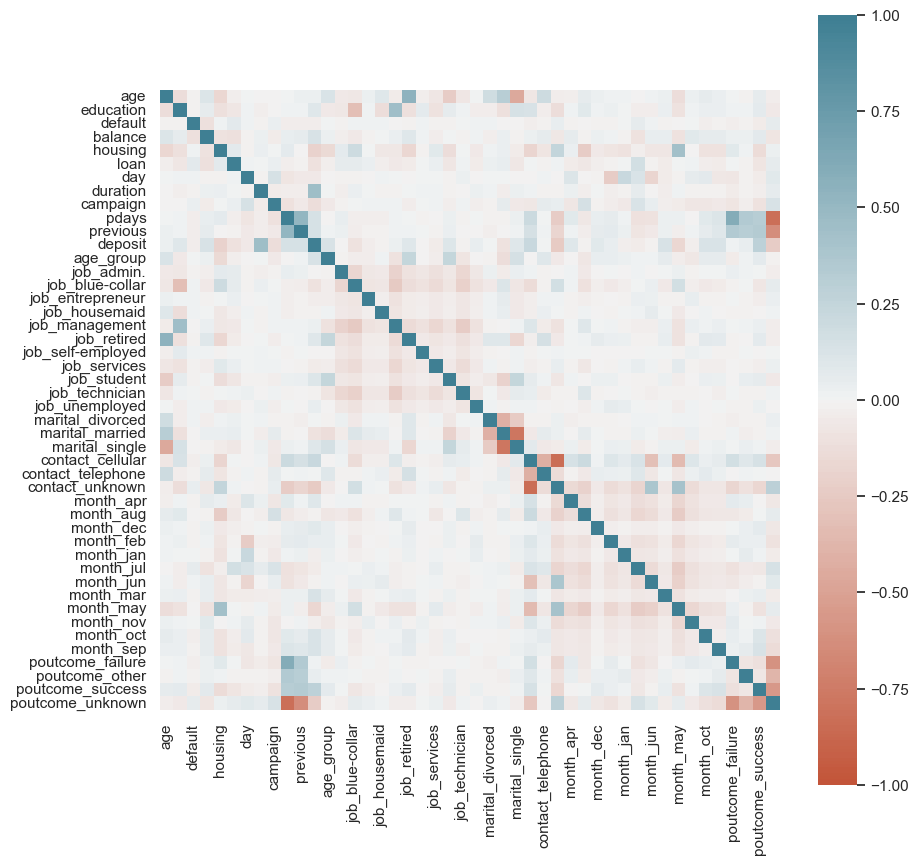

In [133]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corr = df.corr()

sns.set(rc={'figure.figsize':(10, 10)})

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)
plt.show()

Большой коэффициент корреляции наблюдается между признаками previous, poutcome_unknown и pdays 

### Задания 7 и 8

In [134]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [135]:
# рассчитайте необходимые показатели
X_test.shape

(3335, 45)

### Задание 9

In [136]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)

select_feature = selector.get_feature_names_out()
print(select_feature)

['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous' 'age_group'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


In [137]:
X = df[['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown']]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

### Задание 10

In [138]:
# нормализуйте данные с помощью minmaxsxaler
X_train = X_train[select_feature]
X_test = X_test[select_feature]

scaler = preprocessing.MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)
X_train = pd.DataFrame(scaled_X_train, columns=select_feature)
X_test = pd.DataFrame(scaled_X_test, columns=select_feature)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [139]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000 )

log_reg.fit(X_train, y_train)
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

print('Значение f1-score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Значение f1-score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Значение accuracy на тренировочном наборе: {:.2f}'.format(log_reg.score(X_train, y_train)))
print('Значение accuracy на тестовом наборе: {:.2f}'.format(log_reg.score(X_test, y_test)))

Значение f1-score на тренировочном наборе: 0.80
Значение f1-score на тестовом наборе: 0.78
Значение accuracy на тренировочном наборе: 0.82
Значение accuracy на тестовом наборе: 0.80


### Задания 2,3,4

In [140]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

dt.fit(X_train, y_train)
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)


print('Значение f1-score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Значение f1-score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Значение accuracy на тренировочном наборе: {:.2f}'.format(dt.score(X_train, y_train)))
print('Значение accuracy на тестовом наборе: {:.2f}'.format(dt.score(X_test, y_test)))

Значение f1-score на тренировочном наборе: 1.00
Значение f1-score на тестовом наборе: 0.72
Значение accuracy на тренировочном наборе: 1.00
Значение accuracy на тестовом наборе: 0.75


In [141]:
dt_1 = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 7
)

dt_1.fit(X_train, y_train)
y_train_pred = dt_1.predict(X_train)
y_test_pred = dt_1.predict(X_test)


print('Значение f1-score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Значение f1-score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Значение accuracy на тренировочном наборе: {:.2f}'.format(dt_1.score(X_train, y_train)))
print('Значение accuracy на тестовом наборе: {:.2f}'.format(dt_1.score(X_test, y_test)))

Значение f1-score на тренировочном наборе: 0.83
Значение f1-score на тестовом наборе: 0.81
Значение accuracy на тренировочном наборе: 0.84
Значение accuracy на тестовом наборе: 0.82


### Задание 5

In [142]:
# подберите оптимальные параметры с помощью gridsearch
dt = tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=42
)
param_grid = {
    'min_samples_split': [2, 5, 7, 10, 12],
    'max_depth':[3,5,7,10, 15]
}

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
y_test_pred = grid_search.predict(X_test)

print('Наилучшие значения параметров: {}'.format(grid_search.best_params_))
print('Значение f1-score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Значение f1-score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Значение accuracy на тренировочном наборе: {:.2f}'.format(grid_search.score(X_train, y_train)))
print('Значение accuracy на тестовом наборе: {:.2f}'.format(grid_search.score(X_test, y_test)))

Наилучшие значения параметров: {'max_depth': 7, 'min_samples_split': 12}
Значение f1-score на тренировочном наборе: 0.83
Значение f1-score на тестовом наборе: 0.81
Значение accuracy на тренировочном наборе: 0.84
Значение accuracy на тестовом наборе: 0.82


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [143]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=12,
    max_depth=7,
    random_state=42
)

rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print('Значение f1-score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Значение f1-score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Значение accuracy на тренировочном наборе: {:.2f}'.format(rf.score(X_train, y_train)))
print('Значение accuracy на тестовом наборе: {:.2f}'.format(rf.score(X_test, y_test)))

Значение f1-score на тренировочном наборе: 0.83
Значение f1-score на тестовом наборе: 0.81
Значение accuracy на тренировочном наборе: 0.84
Значение accuracy на тестовом наборе: 0.82


### Задания 2 и 3

In [144]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=12,
    max_depth=7,
    random_state=42
)
gb.fit(X_train, y_train)

y_train_pred = gb.predict(X_train)
y_test_pred = gb.predict(X_test)


print('Значение f1-score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Значение f1-score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Значение accuracy на тренировочном наборе: {:.2f}'.format(gb.score(X_train, y_train)))
print('Значение accuracy на тестовом наборе: {:.2f}'.format(gb.score(X_test, y_test)))

Значение f1-score на тренировочном наборе: 0.91
Значение f1-score на тестовом наборе: 0.81
Значение accuracy на тренировочном наборе: 0.92
Значение accuracy на тестовом наборе: 0.82


Градиентный бустинг показывает лучшие результаты.

### Задание 4

In [145]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('dt_1', tree.DecisionTreeClassifier(
        criterion='entropy',
        max_depth=7,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42,
        max_iter=1000 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=12,
        max_depth=7,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train, y_train)
y_train_pred = stack.predict(X_train)
y_test_pred = stack.predict(X_test)

print('Метрики на тренировочном наборе: ')
print(metrics.classification_report(y_train, y_train_pred))
print('Метрики на тестовом наборе: ')
print(metrics.classification_report(y_test, y_test_pred))

print('Значение f1-score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Значение f1-score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Значение accuracy на тренировочном наборе: {:.2f}'.format(stack.score(X_train, y_train)))
print('Значение accuracy на тестовом наборе: {:.2f}'.format(stack.score(X_test, y_test)))

Метрики на тренировочном наборе: 
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3634
           1       0.87      0.87      0.87      3136

    accuracy                           0.88      6770
   macro avg       0.88      0.88      0.88      6770
weighted avg       0.88      0.88      0.88      6770

Метрики на тестовом наборе: 
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

Значение f1-score на тренировочном наборе: 0.87
Значение f1-score на тестовом наборе: 0.81
Значение accuracy на тренировочном наборе: 0.88
Значение accuracy на тестовом наборе: 0.82


### Задание 5

In [146]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
gboost = ensemble.GradientBoostingClassifier(
    learning_rate=0.05, n_estimators=300, min_samples_leaf=12, 
    max_depth=7, random_state=42)
gboost.fit(X_train, y_train)

print(sorted(list(zip(select_feature, gboost.feature_importances_)), 
       key=lambda x: x[1], reverse=True)[:3])

[('duration', 0.4746115566609877), ('poutcome_success', 0.11804521913210457), ('balance', 0.09132169924446602)]


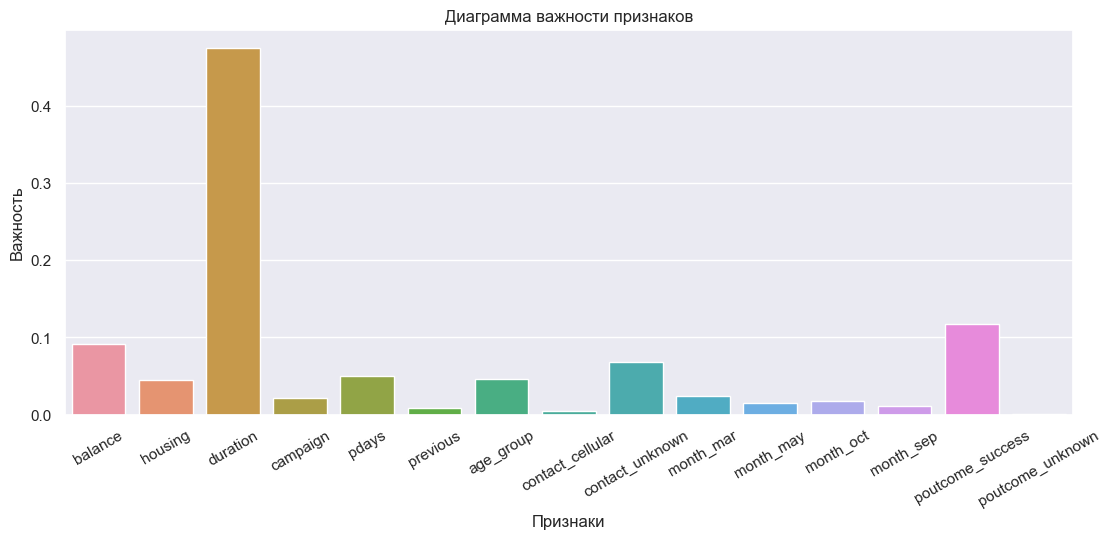

In [147]:
#либо с помощью графика
fig, ax = plt.subplots(figsize=(13, 5))
columns_name = X_train.columns
feature_importances = gb.feature_importances_
main_plot = sns.barplot(x=columns_name, y=feature_importances, ax=ax);
ax.set_title('Диаграмма важности признаков')
ax.set_xlabel('Признаки')
ax.set_ylabel('Важность')
main_plot.xaxis.set_tick_params(rotation=30);

In [148]:
# или так
estimator = gb
selector = RFE(estimator, n_features_to_select = 3, step=1)
selector = selector.fit(X_train,y_train)
selector.get_feature_names_out()

array(['balance', 'duration', 'poutcome_success'], dtype=object)

Самые "сильные" признаки - duration, poutcome_success, balance.

### Задания 6,7,8

In [149]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [150]:
%%time
study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
study.optimize(optuna_rf, n_trials=20)

CPU times: total: 54.6 s
Wall time: 1min 13s


In [151]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [152]:
print('Метрики на тренировочном наборе: ')
print(metrics.classification_report(y_train, y_train_pred))
print('Метрики на тестовом наборе: ')
print(metrics.classification_report(y_test, y_test_pred))


print('Наилучшие значения гиперпараметров {}'.format(study.best_params))
print('Значение f1-score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Значение f1-score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Значение accuracy на тренировочном наборе: {:.2f}'.format(model.score(X_train, y_train)))
print('Значение accuracy на тестовом наборе: {:.2f}'.format(model.score(X_test, y_test)))

Метрики на тренировочном наборе: 
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      3634
           1       0.91      0.94      0.93      3136

    accuracy                           0.93      6770
   macro avg       0.93      0.93      0.93      6770
weighted avg       0.93      0.93      0.93      6770

Метрики на тестовом наборе: 
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1790
           1       0.79      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

Наилучшие значения гиперпараметров {'n_estimators': 141, 'max_depth': 26, 'min_samples_leaf': 2}
Значение f1-score на тренировочном наборе: 0.93
Значение f1-score на тестовом наборе: 0.82
Значение accuracy на тренировочном наборе: 0.93
Значение accuracy на тестовом наборе: 0.83
